In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision as tv
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import tv_tensors  # we'll describe this a bit later, bare with us

import torchvision.datasets as datasets
from pathlib import Path

from torchview import draw_graph

import constants
import dataset
import util

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():      
    device = 'mps'                         
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)


%load_ext autoreload
%autoreload 2


using device: mps


In [ ]:
print(constants)
print(constants.SOURCE_DIR)
print(constants.FLICKR30k_IMAGE_DIR)

In [96]:
coco = dataset.Coco()
img = coco.__getitem__(0)

Found annotations at '/Users/xiangyuliu/sources/fiftyone_dataset_zoo/coco-2017/raw/instances_train2017.json'


[autoreload of imagedata failed: Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 990, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1128, in get_code
  File "<frozen importlib._bootstrap_external>", line 1058, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/Users/xiangyuliu/sources/scpd/cs231n/project/src/imageda

Images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


TypeError: ImageData.__init__() takes 4 positional arguments but 5 were given

In [88]:
print(img.image_id)
print(img.image_path)
import os
print(os.path.basename(img.image_path))
print(int(os.path.basename(img.image_path).removesuffix('.jpg')))

9
/Users/xiangyuliu/sources/fiftyone_dataset_zoo/coco-2017/train/data/000000000009.jpg
000000000009.jpg
9


In [76]:
import json 
import pandas as pd

with open(constants.CAPTION_TRAIN, 'r') as f:
    data = json.load(f)
    captions = pd.DataFrame(data['annotations'], columns=['image_id', 'id', 'caption'])

In [92]:
c = captions.loc[captions['image_id'] == 9, ['caption']].values.flatten().tolist()
print(c)

['Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.']


In [78]:
print(coco.dataset)

Name:        coco-2017-train
Media type:  image
Num samples: 118287
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [ ]:
item = coco_train.__getitem__(0)

In [ ]:
item = flickr30k.__getitem__(0)

In [ ]:
print(item)

In [ ]:
image = item.image()

In [ ]:
print(item.annotations)

In [ ]:

bounding_box = tv_tensors.BoundingBoxes(item.annotations['boxes'], format="XYXY", canvas_size=item.image().shape[-2:])

In [ ]:

boxset = set()
for k, v in item.annotations['boxes'].items():
    print(v)
    print()
    boxset.update(set(map(tuple, v)))

print(boxset)


In [ ]:
image = item.image()
util.plot([(item.image(), bounding_box)])

In [ ]:
item.sentences

In [ ]:
item.annotations

In [ ]:
list1 = []
list1 += item.annotations['boxes']['112625']
list1 += item.annotations['boxes']['112630']
list1

In [ ]:
boxes = tv_tensors.BoundingBoxes(item.annotations['boxes']['112630'],
    format="XYXY", canvas_size=item.image().shape[-2:])
print(boxes)
util.plot([(item.image(), boxes)])

In [ ]:
boxes = tv_tensors.BoundingBoxes(list1,
    format="XYXY", canvas_size=item.image().shape[-2:])
util.plot([(item.image(), boxes)])

In [24]:
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval().to(device)

# from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights


# weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

# model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
# model = model.eval().to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
from torchviz import make_dot
from IPython.display import Image, display

random_inp = torch.rand(10, 3, 600, 480).to(device)
predictions = model(random_inp)

In [ ]:
print(
    dict(list(model.named_parameters())))

In [3]:
print(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [35]:
transform = model.transform
backbone = model.backbone
#model_graph = draw_graph(model.backbone, input_size=(batch_size, 3, 244, 244), device='mps', depth= 10)

random_inp = torch.rand(10, 3, 600, 480).to("mps")
after, stuff = transform(random_inp, None)
print(after)
backbone_out = backbone(after.tensors)

In [36]:
for k,v in backbone_out.items():
    print(k, v.shape)

0 torch.Size([10, 256, 256, 200])
1 torch.Size([10, 256, 128, 100])
2 torch.Size([10, 256, 64, 50])
3 torch.Size([10, 256, 32, 25])
pool torch.Size([10, 256, 16, 13])


In [37]:
random_inp = torch.rand(10, 3, 24, 480).to("mps")
after, stuff = transform(random_inp, None)
print(after)
backbone_out = backbone(after.tensors)
for k,v in backbone_out.items():
    print(k, v.shape)

0 torch.Size([10, 256, 24, 336])
1 torch.Size([10, 256, 12, 168])
2 torch.Size([10, 256, 6, 84])
3 torch.Size([10, 256, 3, 42])
pool torch.Size([10, 256, 2, 21])


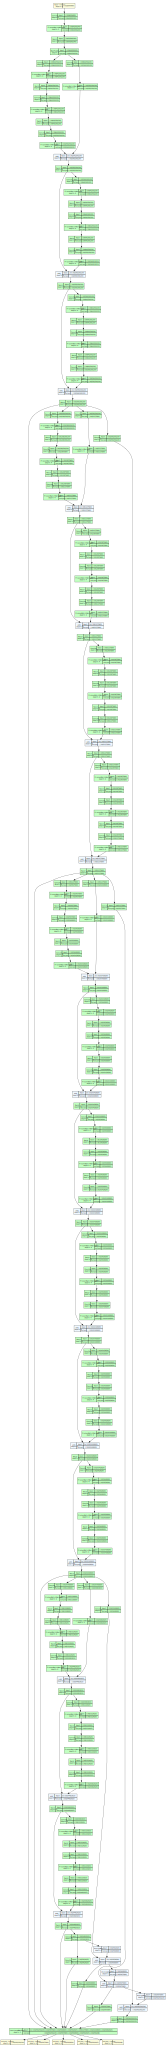

In [10]:
batch_size = 2
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model.backbone, input_size=(10, 3, 600, 480), device='mps', depth= 10)
model_graph.visual_graph

In [31]:
for k,v in backbone_out.items():
    print(k, v.shape)

0 torch.Size([10, 256, 256, 200])
1 torch.Size([10, 256, 128, 100])
2 torch.Size([10, 256, 64, 50])
3 torch.Size([10, 256, 32, 25])
pool torch.Size([10, 256, 16, 13])


In [ ]:

dot = make_dot(predictions, params=dict(list(model.named_parameters())))
# Save the dot file as a PNG
dot.format = 'png'
dot.render('maskrcnn_resnet50_fpn_torchviz')

# Display the saved PNG in the notebook
display(Image('maskrcnn_resnet50_fpn_torchviz.png'))

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

# # List available zoo datasets
print(foz.list_zoo_datasets())

# #
# # Load the COCO-2017 validation split into a FiftyOne dataset
# #
# # This will download the dataset from the web, if necessary
# #
dataset = foz.load_zoo_dataset("coco-2017",    split="validation")

# # Give the dataset a new name, and make it persistent so that you can
# # work with it in future sessions
dataset.name = "coco-2017"
dataset.persistent = True

# # Visualize the in the App
session = fo.launch_app(dataset)

In [ ]:


session = fo.launch_app(dataset)

In [ ]:

import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
  "coco-2014", 
  split="validation",
  label_types=["detections", "caption"],
  max_samples=250,
)
session = fo.launch_app(dataset)

In [ ]:
print("foo")
print(dataset)

In [1]:
from transformers import BertConfig, BertModel

In [51]:
from transformers import AutoTokenizer, BertModel
import torch

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertModel.from_pretrained("google-bert/bert-base-uncased")

print(tokenizer)
inputs = tokenizer(["Two men talking on the street",
                    "Foo"], padding=True , return_tensors="pt")
outputs = model(**inputs)



BertTokenizerFast(name_or_path='google-bert/bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [52]:
print(model.config.hidden_size)
print(outputs.last_hidden_state.shape)


768
torch.Size([2, 8, 768])


In [43]:
print(inputs)


{'input_ids': tensor([[ 101, 2048, 2273, 3331, 2006, 1996, 2395,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [9]:
print(outputs.last_hidden_state.shape)
print(outputs.pooler_output.shape)

torch.Size([1, 8, 768])
torch.Size([1, 768])


In [20]:

inputs = tokenizer("this is a super super long super long super long super long super long super long super long super long super long super long super long super long super long super long super long hotdog", return_tensors="pt")
_, output = model(**inputs)
print(outputs.last_hidden_state.shape)
print(outputs.pooler_output.shape)

torch.Size([1, 38, 768])
torch.Size([1, 768])


In [19]:
print(last_hidden_states.shape)
print(outputs.pooler_output.shape)

torch.Size([1, 4, 768])
torch.Size([1, 768])


In [ ]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased')
unmasker("The man worked as a [MASK].")
